In [27]:
from scipy.integrate import odeint
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import lombscargle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import scipy.signal as signal
import itertools
import random
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [28]:
def extract_features(x, y, v_x, v_y):
    """
    Extract features from the time series data for use in machine learning models.

    :param x: X position data array.
    :param y: Y position data array.
    :param v_x: X velocity data array.
    :param v_y: Y velocity data array.
    :return: Extracted features.
    """
    features = {
        'x_mean': np.mean(x),
        'y_mean': np.mean(y),
        'x_var': np.var(x),
        'y_var': np.var(y),
        'x_skew': skew(x),
        'y_skew': skew(y),
        'x_kurt': kurtosis(x),
        'y_kurt': kurtosis(y),
        'v_x_mean': np.mean(v_x),
        'v_y_mean': np.mean(v_y),
        'v_x_var': np.var(v_x),
        'v_y_var': np.var(v_y),
        'v_x_skew': skew(v_x),
        'v_y_skew': skew(v_y),
        'v_x_kurt': kurtosis(v_x),
        'v_y_kurt': kurtosis(v_y),
    }
    
    return features

In [29]:
def subsample_time_series(t, x, y, v_x, v_y, subsample_size=30):
    """
    Subsample the time series data to simulate incomplete observations.

    :param t: Time points array.
    :param x: X position data array.
    :param y: Y position data array.
    :param v_x: X velocity data array.
    :param v_y: Y velocity data array.
    :param subsample_size: The number of data points to subsample to.
    :return: Subsampled time series data.
    """
    # Ensure we always subsample the same way for reproducibility
    np.random.seed(0)
    
    # Choose random indices for subsampling
    subsample_indices = np.random.choice(len(t), size=subsample_size, replace=False)
    subsample_indices.sort()  # Sort the indices to maintain the time order
    
    return t[subsample_indices], x[subsample_indices], y[subsample_indices], v_x[subsample_indices], v_y[subsample_indices]

In [30]:
def remove_outliers(df, column_names):
    """
    Remove outliers from a pandas DataFrame based on the interquartile range.

    :param df: Pandas DataFrame.
    :param column_names: List of column names to check for outliers.
    :return: DataFrame with outliers removed.
    """
    clean_df = df.copy()
    
    for column in column_names:
        Q1 = clean_df[column].quantile(0.10)
        Q3 = clean_df[column].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        clean_df = clean_df[(clean_df[column] >= lower_bound) & (clean_df[column] <= upper_bound)]
    
    return clean_df

In [31]:
def simulate_system(func, initial_conditions, t, params):
    """
    Generalized simulation function for different potentials.

    :param func: Function representing the equations of motion.
    :param initial_conditions: Initial conditions for the simulation.
    :param t: Array of time points for the simulation.
    :param params: Parameters required for the specific potential.
    :return: Simulated time series data.
    """
    solution = odeint(func, initial_conditions, t, args=params)

    x = solution[:,0]
    y = solution[:,1]
    v_x = solution[:,2]
    v_y = solution[:,3]
    
    return x, y, v_x, v_y


In [32]:
def simulate_harmonic_oscillator(initial_conditions, t, omega, a):
    def equations_of_motion(xyv_xv_y, t, omega, a):
        x, y, v_x, v_y = xyv_xv_y
        return [v_x, v_y, a - omega**2 * x, a - omega**2 * y]
    
    return simulate_system(equations_of_motion, initial_conditions, t, (omega, a))

In [33]:
def simulate_modified_newtonian(initial_conditions, t, b, a):
    def equations_of_motion(xyv_xv_y, t, b, a):
        x, y, v_x, v_y = xyv_xv_y
        return [v_x, v_y, -x / (x**2 + y**2)**(3/2), -y / (x**2 + y**2)**(3/2)]

    return simulate_system(equations_of_motion, initial_conditions, t, (b, a))

In [34]:
def generate_sine_wave(t, A, w, psi):

    sigma = 0.2*A
    w_noise = np.random.default_rng(2).normal(0, sigma , 100)
    
    wave = A * (np.sin(w*t + psi) + w_noise)     
    
    return wave

def extract_features_from_wave(x, t):
    """
    Extract features from the wave time series data for use in machine learning models.

    :param x: Wave data array (either sine or cosine wave).
    :param t: Time points array corresponding to the wave data.
    :return: Extracted features as a dictionary.
    """
    # Example feature extraction from the wave
    v_x = np.gradient(x, t)  # Derivative of x to simulate velocity-like feature

    features = {
        'x_mean': np.mean(x),
        'y_mean': 0,  # Placeholder as sine/cosine waves don't have y-component
        'x_var': np.var(x),
        'y_var': 0,  # Placeholder
        'x_skew': skew(x),
        'y_skew': 0,  # Placeholder
        'x_kurt': kurtosis(x),
        'y_kurt': 0,  # Placeholder
        'v_x_mean': np.mean(v_x),
        'v_y_mean': 0,  # Placeholder for velocity in y-direction
        'v_x_var': np.var(v_x),
        'v_y_var': 0,  # Placeholder
        'v_x_skew': skew(v_x),
        'v_y_skew': 0,  # Placeholder
        'v_x_kurt': kurtosis(v_x),
        'v_y_kurt': 0,  # Placeholder
        # Additional features can be added here if necessary
    }
    
    return features

In [35]:
#Ondas seno

seed_value = 40
rng = np.random.default_rng(seed_value)

w = rng.uniform(0.1, 9.5, 5)
A = rng.uniform(0.1, 5, 5)
psi = rng.uniform(0.1, 10, 5)

t = rng.uniform(0, 30, 100)
t.sort()

data_features = []
data_frec = []

for i in w:
    for j in A:
        for k in psi:

            x = generate_sine_wave(t, j, i, k)

            #Calculamos la frecuencia
            frec = i

            # Extract features from the time series data
            features = extract_features_from_wave(x, t)

            # Store the features and peak frequency
            data_features.append(features)
            data_frec.append(frec)
            
 # Convert lists to a DataFrame
features_df = pd.DataFrame(data_features)
features_df['Frecuency'] = data_frec       

In [36]:
#Harmonic potencial

initial_conditions=[1., 0., 0., 0.1]
subsample_size = 30
seed_value = 20
rng = np.random.default_rng(seed_value)


t = rng.uniform(0, 30, 100)
t.sort()

omega = rng.uniform(0, 5, 500)

for i in omega:
    
    x = simulate_harmonic_oscillator(initial_conditions, t, i, 0)[0]
    y = simulate_harmonic_oscillator(initial_conditions, t, i, 0)[1]
    v_x = simulate_harmonic_oscillator(initial_conditions, t, i, 0)[2]
    v_y = simulate_harmonic_oscillator(initial_conditions, t, i, 0)[3]

    frec = 1/i
    
    # Subsample the time series data to simulate incomplete observations
    t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)

    # Extract features from the subsampled time series data
    features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)

     # Store the features and peak frequency
    data_features.append(features)
    data_frec.append(frec)

# Convert lists to a DataFrame
features_df = pd.DataFrame(data_features)
features_df['Frecuency'] = data_frec

 # Save the DataFrame to a CSV file
#features_df.to_csv('simulated_time_series_data.csv', index=False)

In [37]:
#Kepler potencial

seed_value = 30
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 30, 100)
t.sort()

y0 = rng.uniform(0., 0.1, 15)
v_x_0 = rng.uniform(0.1, 0.9, 15)
v_y_0 = rng.uniform(0., 0.6, 15)

for i in y0:
    for j in v_x_0:
        for k in v_y_0:

            initial_conditions = [1., i, j, k]
            
            x = simulate_modified_newtonian(initial_conditions, t, 1, 1)[0]
            y = simulate_modified_newtonian(initial_conditions, t, 1, 1)[1]
            v_x = simulate_modified_newtonian(initial_conditions, t, 1, 1)[2]
            v_y = simulate_modified_newtonian(initial_conditions, t, 1, 1)[3]

         
            #calculamos el periodo
            r = np.sqrt(1+i**2)
            v = j**2+k**2
            a = 1 / (2/r - v)  #semi eje mayor
            frec = 1/np.sqrt(a**3)
            
            # Subsample the time series data to simulate incomplete observations
            t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)

            # Extract features from the subsampled time series data
            features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)

             # Store the features and peak frequency
            data_features.append(features)
            data_frec.append(frec)

# Convert lists to a DataFrame
features_df = pd.DataFrame(data_features)
features_df['Frecuency'] = data_frec

 # Save the DataFrame to a CSV file
features_df.to_csv('simulated_time_series_data.csv', index=False)

/home/anakin/miniconda3/envs/ml/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [38]:
features_df

,x_mean,y_mean,x_var,y_var,x_skew,y_skew,x_kurt,y_kurt,v_x_mean,v_y_mean,v_x_var,v_y_var,v_x_skew,v_y_skew,v_x_kurt,v_y_kurt,Frecuency
0,0.026837,0.000000,23.721869,0.000000,0.193948,0.000000,-0.552278,0.000000,202.590224,0.000000,1.756133e+06,0.000000,6.611847,0.000000,42.642461,0.000000,6.961046
1,0.021519,0.000000,23.765251,0.000000,0.201113,0.000000,-0.565930,0.000000,202.597938,0.000000,1.756036e+06,0.000000,6.611882,0.000000,42.642856,0.000000,6.961046
2,-0.136439,0.000000,25.358238,0.000000,0.314215,0.000000,-0.446781,0.000000,202.394931,0.000000,1.748882e+06,0.000000,6.606254,0.000000,42.588016,0.000000,6.961046
3,-0.081260,0.000000,24.622338,0.000000,0.262676,0.000000,-0.576650,0.000000,202.564454,0.000000,1.752362e+06,0.000000,6.609712,0.000000,42.622093,0.000000,6.961046
4,-0.073044,0.000000,24.543622,0.000000,0.258360,0.000000,-0.591203,0.000000,202.579381,0.000000,1.752777e+06,0.000000,6.610074,0.000000,42.625631,0.000000,6.961046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.127047,0.714593,0.277241,0.126184,-0.998279,-0.935086,-0.252398,-0.132544,0.001445,-0.084131,5.901747e-01,0.689421,2.106207,-2.665755,6.657245,7.484837,1.024070
3996,1.124330,0.639499,0.246404,0.141125,-1.073368,-0.713780,0.162410,-0.940692,-0.039973,-0.042959,4.396081e-01,0.673994,0.668180,-2.710493,0.129848,6.636514,1.072304
3997,1.282758,0.351172,0.099613,0.018792,-2.068610,-1.078252,4.469265,0.114557,-0.105096,0.035352,4.931668e-01,0.121915,-1.404390,-4.227241,4.901783,18.609927,1.373448
3998,1.160808,0.769144,0.182790,0.131835,-0.919501,-0.604217,-0.251564,-0.717949,-0.071192,0.116751,3.039019e-01,0.181481,0.212143,-0.993166,-0.677654,-0.145606,0.984228


In [39]:
features_df.isna().sum()

x_mean       0
y_mean       0
x_var        0
y_var        0
x_skew       0
y_skew       0
x_kurt       0
y_kurt       0
v_x_mean     0
v_y_mean     0
v_x_var      0
v_y_var      0
v_x_skew     0
v_y_skew     0
v_x_kurt     0
v_y_kurt     0
Frecuency    0
dtype: int64

In [40]:
features_df.fillna(0, inplace=True)
features_df.dropna(inplace=True)

In [41]:
features_df.corr()

,x_mean,y_mean,x_var,y_var,x_skew,y_skew,x_kurt,y_kurt,v_x_mean,v_y_mean,v_x_var,v_y_var,v_x_skew,v_y_skew,v_x_kurt,v_y_kurt,Frecuency
x_mean,1.000000,0.605435,-0.242520,0.329769,-0.824322,-0.536798,0.606092,0.345105,-0.235289,0.017199,-0.189314,-0.029261,-0.143477,-0.352917,-0.144384,0.357308,-0.005755
y_mean,0.605435,1.000000,-0.138646,0.782104,-0.328245,-0.540286,0.176458,0.325540,-0.148624,0.023054,-0.122332,-0.033435,0.007801,-0.152199,-0.137827,-0.009318,0.070504
x_var,-0.242520,-0.138646,1.000000,-0.137575,0.216163,0.134082,-0.036813,0.208529,0.966675,0.004724,0.988821,-0.007753,0.480469,0.159379,0.593022,-0.132232,0.066870
y_var,0.329769,0.782104,-0.137575,1.000000,-0.089456,-0.147956,-0.085154,-0.053935,-0.147374,0.002376,-0.121486,-0.008810,0.045223,-0.104931,-0.144539,-0.086967,0.219167
x_skew,-0.824322,-0.328245,0.216163,-0.089456,1.000000,0.392656,-0.851901,-0.275191,0.204439,-0.047410,0.172056,0.071352,0.258394,0.391116,0.200142,-0.363628,0.010035
y_skew,-0.536798,-0.540286,0.134082,-0.147956,0.392656,1.000000,-0.298034,-0.522410,0.140385,-0.022008,0.111436,0.039928,0.073382,0.112219,0.144036,-0.038088,0.051073
x_kurt,0.606092,0.176458,-0.036813,-0.085154,-0.851901,-0.298034,1.000000,0.291154,-0.019671,0.044295,-0.014580,-0.064692,-0.114121,-0.230030,0.013182,0.391399,-0.012968
y_kurt,0.345105,0.325540,0.208529,-0.053935,-0.275191,-0.522410,0.291154,1.000000,0.236740,0.025734,0.192188,-0.037257,0.216531,0.068148,0.244373,-0.095737,0.005057
v_x_mean,-0.235289,-0.148624,0.966675,-0.147374,0.204439,0.140385,-0.019671,0.236740,1.000000,0.011415,0.933018,-0.054950,0.586407,0.143138,0.659769,-0.124743,0.077297
v_y_mean,0.017199,0.023054,0.004724,0.002376,-0.047410,-0.022008,0.044295,0.025734,0.011415,1.000000,0.003934,-0.112000,-0.006494,0.234579,-0.094483,-0.117632,-0.002992


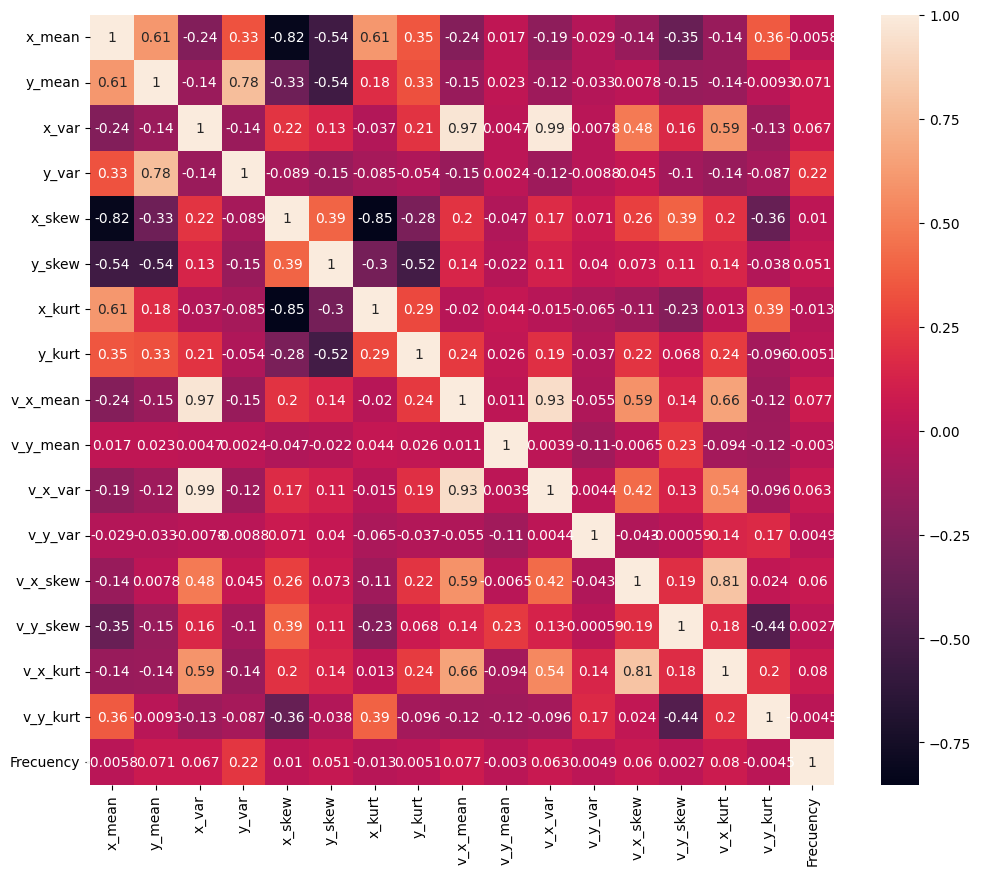

In [42]:
#Perform a correlation matrix to see how the data are related.

plt.figure(figsize=(12,10))
sns.heatmap(features_df.corr(), annot=True)
plt.show()

In [43]:
#Aplicamos el modelo de Machine Learning

data = features_df.copy()

data = remove_outliers(data, ['Frecuency'])

# Split the data into features and target
X = data.drop('Frecuency', axis=1)[['x_mean', 'x_var', 'x_skew', 'x_kurt']]
y = data['Frecuency']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}")
# R2
r2 = rf_regressor.score(X_test, y_test)
print(f"R2 Score: {r2}")

Mean Squared Error: 0.09607681583021006
Mean Absolute Percentage Error: 12.48422924918939
R2 Score: 0.8327859983855898


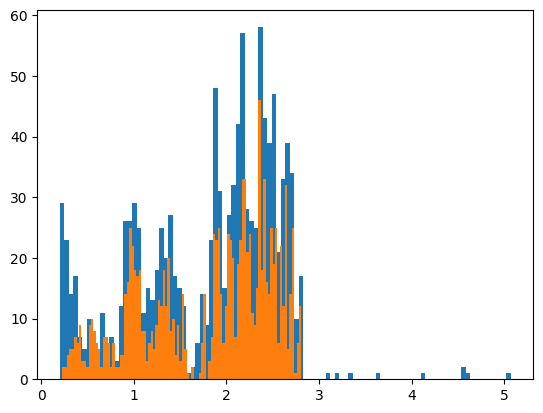

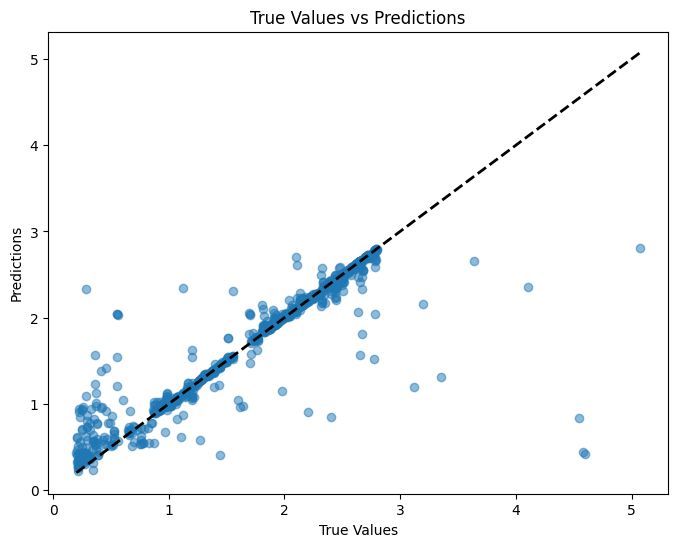

In [44]:
# %%
# Plot histogram of the test and of the predicted values
plt.hist(y_test, bins=100, label='test')    
plt.hist(y_pred, bins=100, label='predicted')

# %%
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [45]:
# %%
# Set the initial conditions
initial_conditions = [1, 0., 0., 0.1]
t_max = 30  # value that we used for training
num_points = 100  # same we used in training
subsample_size = 30  # same we used in training
t = np.linspace(0, t_max, num_points)
# Generate the time series data
#t, x, y, v_x, v_y = simulate_modified_newtonian(initial_conditions, np.linspace(0, t_max, num_points), 1, 1)

x = simulate_modified_newtonian(initial_conditions, t, 1, 1)[0]
y = simulate_modified_newtonian(initial_conditions, t, 1, 1)[1]
v_x = simulate_modified_newtonian(initial_conditions, t, 1, 1)[2]
v_y = simulate_modified_newtonian(initial_conditions, t, 1, 1)[3]

# Subsample the data
t_sub, x_sub, y_sub, v_x_sub, v_y_sub = subsample_time_series(t, x, y, v_x, v_y, subsample_size)

# Extract features
features = extract_features(x_sub, y_sub, v_x_sub, v_y_sub)

# Select only the features used in training
selected_features = ['x_mean', 'x_var', 'x_skew', 'x_kurt']
features_for_prediction = {feature: features[feature] for feature in selected_features}

# Create a DataFrame for prediction
features_df = pd.DataFrame([features_for_prediction])

# Predict with the model
predicted_peak_frequency = rf_regressor.predict(features_df)

print(f"Predicted Peak Frequency: {predicted_peak_frequency[0]}")

Predicted Peak Frequency: 2.4525822388721896


In [52]:
agn_obs = pd.read_csv('/home/anakin/Documents/Tesis/Codigo/observations_AGNs.csv')

In [53]:
agn = agn_obs['AGN_n_obs']

In [54]:
agn_obs

,x_mean,x_var,x_skew,x_kurt,AGN_n_obs
0,-0.078913,0.004096,3.790373,14.107390,0537_n1E3.dat
1,0.348208,0.005075,1.476175,3.139287,1243_n2E2.dat
2,-0.012292,0.004965,1.198445,1.486387,1243_n2E13.dat
3,0.349909,0.004354,2.556895,7.918585,1741_n2E4.dat
4,0.349909,0.004354,2.556895,7.918585,1741_n2E6.dat
5,0.130800,0.006003,-1.241334,1.543714,1741_n1E14.dat
6,-0.177409,0.005390,1.607368,4.967913,1741_n2E20.dat
7,0.285182,0.005205,3.521377,12.540310,1741_n2E9.dat
8,0.349909,0.004354,2.556895,7.918585,1741_n2E17.dat
9,0.108318,0.004560,1.846394,6.178598,1741_n2E19.dat


In [55]:
agn_obs = agn_obs.drop(['AGN_n_obs'], axis=1)

In [56]:
agn_obs

,x_mean,x_var,x_skew,x_kurt
0,-0.078913,0.004096,3.790373,14.107390
1,0.348208,0.005075,1.476175,3.139287
2,-0.012292,0.004965,1.198445,1.486387
3,0.349909,0.004354,2.556895,7.918585
4,0.349909,0.004354,2.556895,7.918585
5,0.130800,0.006003,-1.241334,1.543714
6,-0.177409,0.005390,1.607368,4.967913
7,0.285182,0.005205,3.521377,12.540310
8,0.349909,0.004354,2.556895,7.918585
9,0.108318,0.004560,1.846394,6.178598


In [57]:
# Predict with the model
predicted_peak_frequency = rf_regressor.predict(agn_obs)
for i in range(len(agn)):

    print(f"Predicted Peak Frequency: {predicted_peak_frequency[i]}", 'for AGN:', agn[i] )

Predicted Peak Frequency: 2.600667957546977 for AGN: 0537_n1E3.dat
Predicted Peak Frequency: 2.586622998222712 for AGN: 1243_n2E2.dat
Predicted Peak Frequency: 2.6007530420923426 for AGN: 1243_n2E13.dat
Predicted Peak Frequency: 2.586622998222712 for AGN: 1741_n2E4.dat
Predicted Peak Frequency: 2.586622998222712 for AGN: 1741_n2E6.dat
Predicted Peak Frequency: 2.6281518214402455 for AGN: 1741_n1E14.dat
Predicted Peak Frequency: 2.600667957546977 for AGN: 1741_n2E20.dat
Predicted Peak Frequency: 2.600667957546977 for AGN: 1741_n2E9.dat
Predicted Peak Frequency: 2.586622998222712 for AGN: 1741_n2E17.dat
Predicted Peak Frequency: 2.600667957546977 for AGN: 1741_n2E19.dat
Predicted Peak Frequency: 2.586622998222712 for AGN: 1741_n2E21.dat
Predicted Peak Frequency: 2.586622998222712 for AGN: 1741_n2E3.dat
Predicted Peak Frequency: 2.586622998222712 for AGN: 1741_n2E10.dat
Predicted Peak Frequency: 2.586622998222712 for AGN: 1741_n2E16.dat
Predicted Peak Frequency: 2.586622998222712 for AGN: